In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

from pathlib import Path

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
#import ace_tools as tools

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
BASE_DIR = Path(Path.cwd()).resolve().parent
DATA_DIR = BASE_DIR / 'data'
csv_name = 'trainData.csv'

df = pd.read_csv(DATA_DIR / csv_name)
df.columns

Index(['Race_Time', 'Race_ID', 'Course', 'Distance', 'distanceYards', 'Prize',
       'Going', 'Horse', 'Trainer', 'Jockey', 'betfairSP', 'Position',
       'timeSecs', 'pdsBeaten', 'NMFP', 'Runners', 'Age', 'Speed_PreviousRun',
       'Speed_2ndPreviousRun', 'NMFPLTO', 'MarketOdds_PreviousRun',
       'MarketOdds_2ndPreviousRun', 'TrainerRating', 'JockeyRating',
       'daysSinceLastRun', 'SireRating', 'DamsireRating', 'meanRunners'],
      dtype='object')

In [3]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    X = df.copy()
    ### RELATIVE FEATURES ###
    X['relative_Age'] = X.groupby('Race_ID')['Age'].transform(lambda x: x - x.mean())
    X['relative_Speed_LTO'] = X.groupby('Race_ID')['Speed_PreviousRun'].transform(lambda x: x - x.mean())
    X['jockey_percentile'] = X.groupby('Race_ID')['JockeyRating'].rank(pct=True)
    X['trainer_percentile'] = X.groupby('Race_ID')['TrainerRating'].rank(pct=True)
    X['is_top_jockey'] = X.groupby('Race_ID')['JockeyRating'].transform(lambda x: x == x.max()).astype(int)
    
    X['trainer_jockey_strength'] = X['TrainerRating'] * df['JockeyRating']
    X['prize_per_runner'] = X['Prize'] / X['Runners']
    
    X['avg_speed_last2'] = X[['Speed_PreviousRun', 'Speed_2ndPreviousRun']].mean(axis=1)
    X['days_since_race_bin'] = pd.cut(X['daysSinceLastRun'], bins=[0,14,30,90,365], labels=False)

    X['delta_market_odds'] = X['MarketOdds_PreviousRun'] - X['MarketOdds_2ndPreviousRun']
    X['pct_change_market_odds'] = (
    (X['MarketOdds_PreviousRun'] - X['MarketOdds_2ndPreviousRun']) / X['MarketOdds_2ndPreviousRun']
    )
    X['delta_speed'] = X['Speed_PreviousRun'] - X['Speed_2ndPreviousRun']
    X['adjusted_speed_trend'] = X['delta_speed'] / (X['daysSinceLastRun'] + 1)

    
    ### DATE/TIME FEATURES ###
    X['Race_Time_Parsed'] = pd.to_datetime(X['Race_Time'], dayfirst=True, errors='coerce')
    X['Hour'] = X['Race_Time_Parsed'].dt.hour
    X['Month'] = X['Race_Time_Parsed'].dt.month

    def map_time_of_day(hour):
        if pd.isna(hour):
            return 'Unknown'
        elif hour < 12:
            return 'Morning'
        elif hour < 17:
            return 'Afternoon'
        elif hour < 21:
            return 'Evening'
        else:
            return 'Night'

    def map_season(month):
        if pd.isna(month):
            return 'Unknown'
        elif month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    X['Season'] = X['Month'].apply(map_season)
    X['TimeOfDay'] = X['Hour'].apply(map_time_of_day)
    
    
    return X

In [4]:
df = make_features(df)

leakage_cols = ['betfairSP', 'timeSecs', 'pdsBeaten', 'NMFP', 'Race_Time_Parsed']
df.drop(columns=[col for col in leakage_cols if col in df.columns], inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Drop rows with missing values (or fill them as needed)
df.dropna(inplace=True)

# Define target: assuming 1 if horse won, 0 otherwise (you must create this correctly from Position)
# If Position was dropped above, you should recreate 'target' based on original data
# Example placeholder: simulate a target column
df['target'] = (df['Position'] == 1).astype(int)  # Replace this with real target
df.drop(columns=['Position'], inplace=True)
# Split into featurres and target
X = df.drop(columns=['target', 'Race_ID', 'Horse'])
y = df['target']
race_ids = df['Race_ID']
horses = df['Horse']

# Train/validation split
X_train, X_val, y_train, y_val, race_train, race_val, horse_train, horse_val = train_test_split(
    X, y, race_ids, horses, test_size=0.2, random_state=42
)


# XGBoost model with Platt scaling (sigmoid)
xgb_model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss', random_state=42)
calibrated_model = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=3)
calibrated_model.fit(X_train, y_train)

# Predict and normalize within race
raw_probs = calibrated_model.predict_proba(X_val)[:, 1]
val_df = pd.DataFrame({
    'Race_ID': race_val,
    'Horse': horse_val,
    'raw_prob': raw_probs,
    'target': y_val
})
val_df['Predicted_Probability'] = val_df.groupby('Race_ID')['raw_prob'].transform(lambda x: x / x.sum())

# Evaluate
logloss = log_loss(val_df['target'], val_df['Predicted_Probability'], labels=[0, 1])
brier = brier_score_loss(val_df['target'], val_df['Predicted_Probability'])

# Output
print("Validation Log Loss:", logloss)
print("Validation Brier Score:", brier)
print(val_df.head(10))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Log Loss: 5.102229765257062
Validation Brier Score: 0.2660627642836679
       Race_ID  Horse  raw_prob  target  Predicted_Probability
51079    35195   1496  0.113197       0               0.572724
12407     6254   6812  0.087162       0               0.165013
36641    14679   7656  0.104993       0               1.000000
30492    14481   1772  0.111144       0               0.575651
47384    11127   6755  0.077507       0               0.409104
21432    37806   1058  0.101157       0               0.162347
40354    49414   6358  0.106837       0               1.000000
24404    12245   1389  0.082798       0               0.329527
24199    10418    418  0.156303       0               0.366848
5346      9650   4937  0.090190       0               0.256164


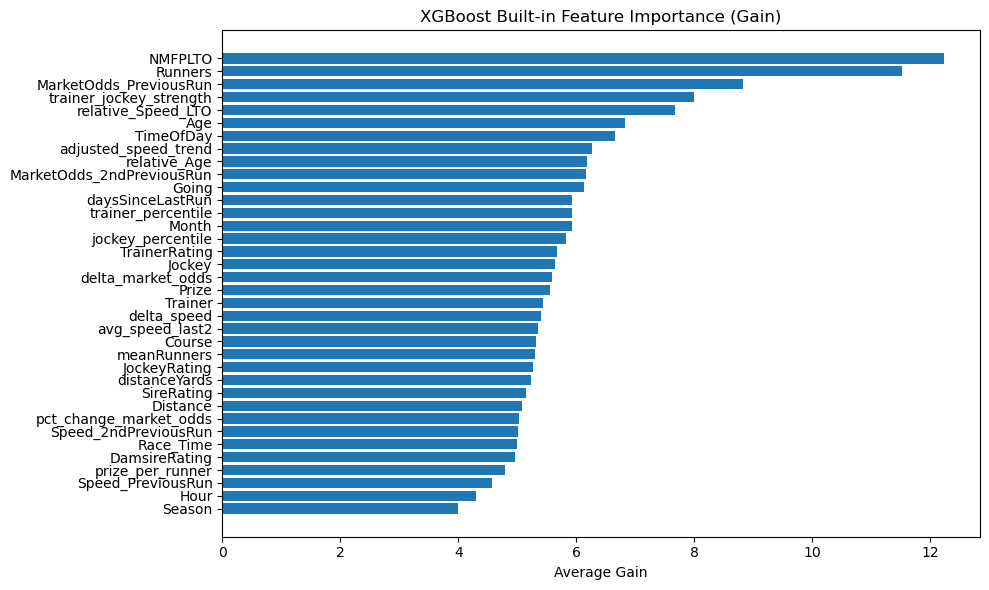

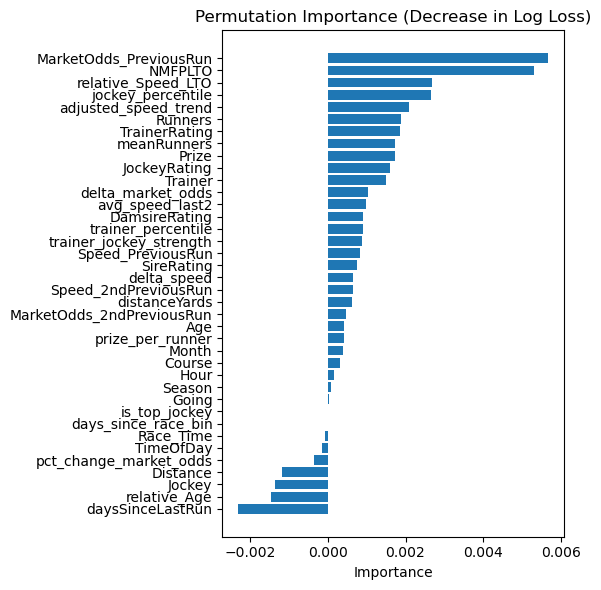

In [5]:
from sklearn.inspection import permutation_importance

# Access the inner XGBoost model (from CalibratedClassifierCV)
xgb_inner = calibrated_model.calibrated_classifiers_[0].estimator

# 1. Built-in Feature Importance (Gain)
booster = xgb_inner.get_booster()
gain_importance = booster.get_score(importance_type='gain')
gain_df = pd.DataFrame(gain_importance.items(), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(gain_df['Feature'], gain_df['Gain'])
plt.title("XGBoost Built-in Feature Importance (Gain)")
plt.xlabel("Average Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Permutation Importance (on subset for speed)
X_val_small = X_val.sample(n=300, random_state=42)
y_val_small = y_val.loc[X_val_small.index]

perm_result = permutation_importance(calibrated_model, X_val_small, y_val_small,
                                     scoring='neg_log_loss', n_repeats=5, random_state=42)
perm_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': perm_result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 6))
plt.barh(perm_df['Feature'], perm_df['Importance'])
plt.title("Permutation Importance (Decrease in Log Loss)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
perm = permutation_importance(xgb_inner, X_val.sample(300), y_val.loc[X_val.sample(300).index], scoring='neg_log_loss', n_repeats=5)
perm_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm.importances_mean})
#perm_df.to_csv("feature_importance_baseline.csv", index=False)

In [16]:
perm_df

,Feature,Importance
0,Race_Time,-0.007923
1,Course,-0.004822
2,Distance,0.003042
3,distanceYards,-0.000478
4,Prize,0.007686
5,Going,0.001010
6,Trainer,0.001252
7,Jockey,0.001621
8,Runners,0.011223
9,Age,-0.004109


In [20]:
top_features = perm_df[perm_df['Importance'] > 0]['Feature'].tolist()

X = df[top_features]
y = df['target']
race_ids = df['Race_ID']
horses = df['Horse']

# Split
X_train, X_val, y_train, y_val, race_train, race_val, horse_train, horse_val = train_test_split(
    X, y, race_ids, horses, test_size=0.2, random_state=42
)
# Retrain with top features
model = CalibratedClassifierCV(XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss'), method='sigmoid', cv=3)
model.fit(X_train, y_train)

# Predict
raw_probs = model.predict_proba(X_val)[:, 1]
val_df = pd.DataFrame({'Race_ID': race_val, 'Horse': horse_val, 'raw_prob': raw_probs, 'target': y_val})
val_df['Predicted_Probability'] = val_df.groupby('Race_ID')['raw_prob'].transform(lambda x: x / x.sum())

# Evaluate
print("Optimized Log Loss:", log_loss(val_df['target'], val_df['Predicted_Probability']))
print("Optimized Brier Score:", brier_score_loss(val_df['target'], val_df['Predicted_Probability']))

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimized Log Loss: 5.104595063656522
Optimized Brier Score: 0.2667867442304108
